<a href="https://colab.research.google.com/github/cogma/llm-book/blob/main/chapter05/5-4-nli-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第5章 大規模言語モデルのファインチューニング

## 5.4 自然言語推論・意味的類似度計算・多肢選択式質問応答モデルの実装

### 5.4.1 自然言語推論

In [1]:
!pip install 'datasets<4.0.0' 'transformers[ja,torch]<4.41.0'  matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.9/694.9 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 78.9 MB/s eta 0:00:00
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha

#### モデルの予測結果の取得

In [2]:
from transformers import pipeline

model_name = "llm-book/bert-base-japanese-v3-jnli"
jnli_pipeline = pipeline(model=model_name, device="cuda:0")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/907 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/606 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [3]:
from datasets import load_dataset

valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JNLI", split="validation"
)

README.md: 0.00B [00:00, ?B/s]

JGLUE.py: 0.00B [00:00, ?B/s]

preprocess_marc_ja.py: 0.00B [00:00, ?B/s]

The repository for llm-book/JGLUE contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/llm-book/JGLUE.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [4]:
from tqdm import tqdm

# ラベル名の情報を取得するためのClassLabelインスタンス
class_label = valid_dataset.features["label"]

results: list[dict[str, float | str]] = []
for i, example in tqdm(enumerate(valid_dataset)):
    # モデルの予測結果を取得
    model_prediction = jnli_pipeline({"text": example["sentence1"], "text_pair": example["sentence2"]})
    # 正解のラベルIDをラベル名に変換
    true_label = class_label.int2str(example["label"])

    # resultsに分析に必要な情報を格納
    results.append(
        {
            "example_id": i,
            "pred_prob": model_prediction["score"],
            "pred_label": model_prediction["label"],
            "true_label": true_label,
        }
    )

1it [00:06,  6.07s/it]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
2434it [00:34, 71.20it/s]


#### 全体的な傾向の分析

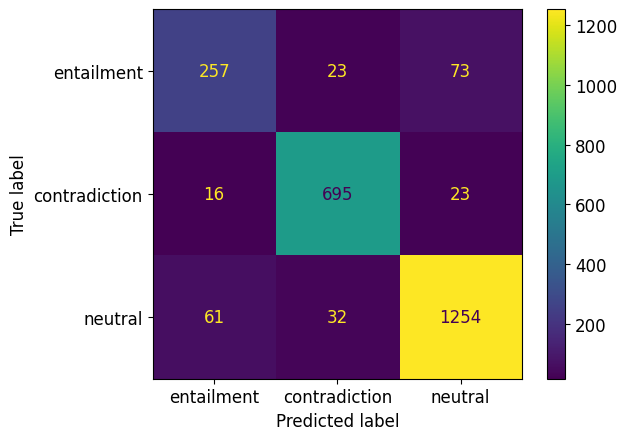

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

plt.rcParams["font.size"] = 12  # 文字サイズを設定

# 混同行列の作成
confusion_matrix = confusion_matrix(
    y_true=[result["true_label"] for result in results],
    y_pred=[result["pred_label"] for result in results],
    labels=class_label.names,
)
# 混同行列を画像として表示
ConfusionMatrixDisplay(
    confusion_matrix, display_labels=class_label.names
).plot()

#### エラー分析

In [6]:
# 予測が誤った事例を収集
failed_results = [
    res for res in results if res["pred_label"] != res["true_label"]
]
# モデルの予測確率が高い順にソート
sorted_failed_results = sorted(
    failed_results, key=lambda x: -x["pred_prob"]
)
# 高い確率で予測しながら誤った事例の上位2件を表示
for top_result in sorted_failed_results[:2]:
    sentence1 = valid_dataset[top_result["example_id"]]["sentence1"]
    sentence2 = valid_dataset[top_result["example_id"]]["sentence2"]

    print(f"前提文：{sentence1}")
    print(f"仮説文：{sentence2}")

    print(f"予測：{top_result['pred_label']}")
    print(f"正解：{top_result['true_label']}")
    print(f"予測確率: {top_result['pred_prob']:.4f}")
    print("----------------")

前提文：おむつをした赤ちゃんが便座の上に立っています。
仮説文：オムツをした赤ちゃんが便座の上に立っています。
予測：contradiction
正解：entailment
予測確率: 0.9997
----------------
前提文：クマがコンクリートの上に座っています。
仮説文：クマが壁にもたれて座っています。
予測：contradiction
正解：neutral
予測確率: 0.9995
----------------
